In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [29]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "Virny":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /Users/denys_herasymuk/UCU/4course_2term/Bachelor_Thesis/Code/Virny


# Multiple Models Interface With Postprocessor

In this example, we are going to audit 4 models for stability and fairness, visualize metrics, and create an analysis report. For that, we will use `compute_metrics_with_config` interface that can compute metrics for multiple models. Thus, we will need to do the next steps:

* Initialize input variables

* Compute subgroup metrics

* Make group metrics composition

* Create metrics visualizations and an analysis report

## Import dependencies

In [30]:
import os
from pprint import pprint
from datetime import datetime, timezone

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from aif360.algorithms.postprocessing import EqOddsPostprocessing

from virny.utils.custom_initializers import create_config_obj, read_model_metric_dfs, create_models_config_from_tuned_params_df
from virny.user_interfaces.multiple_models_api import compute_metrics_with_config
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.custom_classes.metrics_visualizer import MetricsVisualizer
from virny.custom_classes.metrics_composer import MetricsComposer
from virny.utils.model_tuning_utils import tune_ML_models

## Initialize Input Variables

Based on the library flow, we need to create 3 input objects for a user interface:

* A **config yaml** that is a file with configuration parameters for different user interfaces for metrics computation.

* A **dataset class** that is a wrapper above the user’s raw dataset that includes its descriptive attributes like a target column, numerical columns, categorical columns, etc. This class must be inherited from the BaseDataset class, which was created for user convenience.

* Finally, a **models config** that is a Python dictionary, where keys are model names and values are initialized models for analysis. This dictionary helps conduct audits for different analysis modes and analyze different types of models.

In [31]:
DATASET_SPLIT_SEED = 42
MODELS_TUNING_SEED = 42
TEST_SET_FRACTION = 0.2

In [32]:
models_params_for_tuning = {
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(random_state=MODELS_TUNING_SEED),
        'params': {
            "max_depth": [20, 30],
            "min_samples_split" : [0.1],
            "max_features": ['sqrt'],
            "criterion": ["gini", "entropy"]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=MODELS_TUNING_SEED),
        'params': {
            'penalty': ['l2'],
            'C' : [0.0001, 0.1, 1, 100],
            'solver': ['newton-cg', 'lbfgs'],
            'max_iter': [250],
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=MODELS_TUNING_SEED),
        'params': {
            "max_depth": [6, 10],
            "min_samples_leaf": [1],
            "n_estimators": [50, 100],
            "max_features": [0.6]
        }
    },
}

### Create a config object

`compute_metrics_with_config` interface requires that your **yaml file** includes the following parameters:

* **dataset_name**: str, a name of your dataset; it will be used to name files with metrics.

* **bootstrap_fraction**: float, the fraction from a train set in the range [0.0 - 1.0] to fit models in bootstrap (usually more than 0.5).

* **n_estimators**: int, the number of estimators for bootstrap to compute subgroup stability metrics.

* **sensitive_attributes_dct**: dict, a dictionary where keys are sensitive attribute names (including attribute intersections), and values are privileged values for these attributes. Currently, the library supports only intersections among two sensitive attributes. Intersectional attributes must include '&' between sensitive attributes. You do not need to specify privileged values for intersectional groups since they will be derived from privileged values in sensitive_attributes_dct for each separate sensitive attribute in this intersectional pair.

In [33]:
ROOT_DIR = os.path.join('docs', 'examples')
config_yaml_path = os.path.join(ROOT_DIR, 'experiment_config.yaml')
config_yaml_content = """
dataset_name: Law_School
bootstrap_fraction: 0.8
n_estimators: 50  # Better to input the higher number of estimators than 100; this is only for this use case example
sensitive_attributes_dct: {'male': '0.0', 'race': 'Non-White', 'male&race': None}
postprocessing_sensitive_attribute: 'race_binary'
"""

with open(config_yaml_path, 'w', encoding='utf-8') as f:
    f.write(config_yaml_content)

In [34]:
config = create_config_obj(config_yaml_path=config_yaml_path)
SAVE_RESULTS_DIR_PATH = os.path.join(ROOT_DIR, 'results', f'{config.dataset_name}_Metrics_{datetime.now(timezone.utc).strftime("%Y%m%d__%H%M%S")}')

### Preprocess the dataset, create a BaseFlowDataset class, and define a postprocessor

In [35]:
from virny.datasets.data_loaders import LawSchoolDataset

data_loader = LawSchoolDataset()
data_loader.X_data[data_loader.X_data.columns[:5]].head()

,decile1b,decile3,lsat,ugpa,zfygpa
0,10.0,10.0,44.0,3.5,1.33
1,5.0,4.0,29.0,3.5,-0.11
2,8.0,7.0,37.0,3.4,0.63
3,8.0,7.0,43.0,3.3,0.67
4,3.0,2.0,41.0,3.3,-0.67


In [36]:
column_transformer = ColumnTransformer(transformers=[
    ('categorical_features', OneHotEncoder(handle_unknown='ignore', sparse=False), data_loader.categorical_columns),
    ('numerical_features', StandardScaler(), data_loader.numerical_columns),
])

In [37]:
# Create a binary race column for postprocessing since aif360 postprocessors can postprocess a dataset only based on binary columns.
data_loader.X_data['race_binary'] = data_loader.X_data['race'].apply(lambda x: 1 if x == 'White' else 0)

base_flow_dataset = preprocess_dataset(data_loader, column_transformer, TEST_SET_FRACTION, DATASET_SPLIT_SEED)
base_flow_dataset.X_train_val['race_binary'] = data_loader.X_data.loc[base_flow_dataset.X_train_val.index, 'race_binary']
base_flow_dataset.X_test['race_binary'] = data_loader.X_data.loc[base_flow_dataset.X_test.index, 'race_binary']

In [38]:
# Define a postprocessor
privileged_groups = [{'race_binary': 1}]
unprivileged_groups = [{'race_binary': 0}]
postprocessor = EqOddsPostprocessing(privileged_groups=privileged_groups,
                                     unprivileged_groups=unprivileged_groups,
                                     seed=None)

### Tune models and create a models config for metrics computation

In [39]:
tuned_params_df, models_config = tune_ML_models(models_params_for_tuning, base_flow_dataset, config.dataset_name, n_folds=3)
tuned_params_df

2023/12/21, 01:36:28: Tuning DecisionTreeClassifier...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
2023/12/21, 01:36:30: Tuning for DecisionTreeClassifier is finished [F1 score = 0.5243029506705218, Accuracy = 0.8876602564102564]

2023/12/21, 01:36:30: Tuning LogisticRegression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
2023/12/21, 01:36:30: Tuning for LogisticRegression is finished [F1 score = 0.6605519139439457, Accuracy = 0.8993589743589743]

2023/12/21, 01:36:30: Tuning RandomForestClassifier...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
2023/12/21, 01:36:32: Tuning for RandomForestClassifier is finished [F1 score = 0.6531017911447438, Accuracy = 0.8952724358974359]


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Law_School,DecisionTreeClassifier,0.524303,0.887660,"{'criterion': 'gini', 'max_depth': 20, 'max_fe..."
1,Law_School,LogisticRegression,0.660552,0.899359,"{'C': 100, 'max_iter': 250, 'penalty': 'l2', '..."
2,Law_School,RandomForestClassifier,0.653102,0.895272,"{'max_depth': 10, 'max_features': 0.6, 'min_sa..."


In [40]:
now = datetime.now(timezone.utc)
date_time_str = now.strftime("%Y%m%d__%H%M%S")
tuned_df_path = os.path.join(ROOT_DIR, 'results', 'models_tuning', f'tuning_results_{config.dataset_name}_{date_time_str}.csv')
tuned_params_df.to_csv(tuned_df_path, sep=",", columns=tuned_params_df.columns, float_format="%.4f", index=False)

Create models_config from the saved tuned_params_df for higher reliability

In [41]:
models_config = create_models_config_from_tuned_params_df(models_params_for_tuning, tuned_df_path)
pprint(models_config)

{'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_split=0.1,
                       random_state=42),
 'LogisticRegression': LogisticRegression(C=100, max_iter=250, random_state=42, solver='newton-cg'),
 'RandomForestClassifier': RandomForestClassifier(max_depth=10, max_features=0.6, n_estimators=50,
                       random_state=42)}


## Subgroup Metrics Computation

After the variables are input to a user interface, the interface uses subgroup analyzers to compute different sets of metrics for each privileged and disadvantaged subgroup. As for now, our library supports **Subgroup Variance Analyzer** and **Subgroup Error Analyzer**, but it is easily extensible to any other analyzers. When the variance and error analyzers complete metrics computation, their metrics are combined, returned in a matrix format, and stored in a file if defined.

In [42]:
metrics_dct = compute_metrics_with_config(dataset=base_flow_dataset,
                                          config=config,
                                          models_config=models_config,
                                          save_results_dir_path=SAVE_RESULTS_DIR_PATH,
                                          postprocessor=postprocessor,
                                          notebook_logs_stdout=True,
                                          verbose=1)

Analyze models in one run:   0%|          | 0/3 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

Look at several columns in top rows of computed metrics

In [43]:
sample_model_metrics_df = metrics_dct[list(models_config.keys())[0]]
sample_model_metrics_df[sample_model_metrics_df.columns[:6]].head(20)

,Metric,overall,male_priv,male_dis,race_priv,race_dis
0,Statistical_Bias,0.158320,0.146128,0.174431,0.126948,0.332794
1,Aleatoric_Uncertainty,0.387875,0.372405,0.408317,0.325687,0.733735
2,Mean_Prediction,0.107724,0.101227,0.116309,0.077584,0.275348
3,Overall_Uncertainty,0.404555,0.388055,0.426359,0.342643,0.748878
4,IQR,0.047685,0.046265,0.049561,0.046204,0.055917
5,Std,0.038076,0.036202,0.040552,0.036683,0.045819
6,Label_Stability,0.960500,0.967905,0.950714,0.999648,0.742776
7,Jitter,0.026088,0.021304,0.032411,0.000349,0.169238
8,TPR,1.000000,1.000000,1.000000,1.000000,1.000000
9,TNR,0.000000,0.000000,0.000000,0.000000,0.000000


## Group Metrics Composition

**Metrics Composer** is responsible for this second stage of the model audit. Currently, it computes our custom group fairness and stability metrics, but extending it for new group metrics is very simple. We noticed that more and more group metrics have appeared during the last decade, but most of them are based on the same subgroup metrics. Hence, such a separation of subgroup and group metrics computation allows one to experiment with different combinations of subgroup metrics and avoid subgroup metrics recomputation for a new set of grouped metrics.

In [44]:
models_metrics_dct = read_model_metric_dfs(SAVE_RESULTS_DIR_PATH, model_names=list(models_config.keys()))

In [45]:
metrics_composer = MetricsComposer(models_metrics_dct, config.sensitive_attributes_dct)

Compute composed metrics

In [46]:
models_composed_metrics_df = metrics_composer.compose_metrics()

In [47]:
models_composed_metrics_df

,Metric,male,race,male&race,Model_Name
0,Accuracy_Parity,-0.027359,-0.191973,-0.170267,DecisionTreeClassifier
1,Aleatoric_Uncertainty_Parity,0.035912,0.408048,0.382995,DecisionTreeClassifier
2,Aleatoric_Uncertainty_Ratio,1.096432,2.252882,2.071335,DecisionTreeClassifier
3,Equalized_Odds_FNR,0.000000,0.000000,0.000000,DecisionTreeClassifier
4,Equalized_Odds_FPR,0.000000,0.000000,0.000000,DecisionTreeClassifier
5,IQR_Parity,0.003295,0.009713,0.010086,DecisionTreeClassifier
6,Jitter_Parity,0.011107,0.168890,0.161775,DecisionTreeClassifier
7,Label_Stability_Ratio,0.982239,0.743037,0.748244,DecisionTreeClassifier
8,Label_Stability_Difference,-0.017191,-0.256872,-0.246740,DecisionTreeClassifier
9,Overall_Uncertainty_Parity,0.038304,0.406235,0.381743,DecisionTreeClassifier


## Metrics Visualization and Reporting

**Metrics Visualizer** provides metrics visualization and reporting functionality. It unifies different preprocessing methods for result metrics and creates various data formats required for visualizations. Hence, users can simply call methods of the Metrics Visualizer class and get custom plots for diverse metrics analysis. Additionally, these plots could be collected in an HTML report with comments for user convenience and future reference.

In [48]:
visualizer = MetricsVisualizer(models_metrics_dct, models_composed_metrics_df, config.dataset_name,
                               model_names=list(models_config.keys()),
                               sensitive_attributes_dct=config.sensitive_attributes_dct)

In [49]:
visualizer.create_overall_metrics_bar_char(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate', 'Positive-Rate'],
    metrics_title="Error Metrics"
)

alt.Chart(...)

In [50]:
visualizer.create_overall_metrics_bar_char(
    metrics_names=['Label_Stability'],
    reversed_metrics_names=['Std', 'IQR', 'Jitter'],
    metrics_title="Variance Metrics"
)

alt.Chart(...)

Below is an example of an interactive plot. It requires that you run the below cell in Jupyter in the browser or EDAs, which support JavaScript displaying.

You can use this plot to compare any pair of group fairness and stability metrics for all models.

In [51]:
visualizer.create_fairness_variance_interactive_bar_chart()

alt.HConcatChart(...)

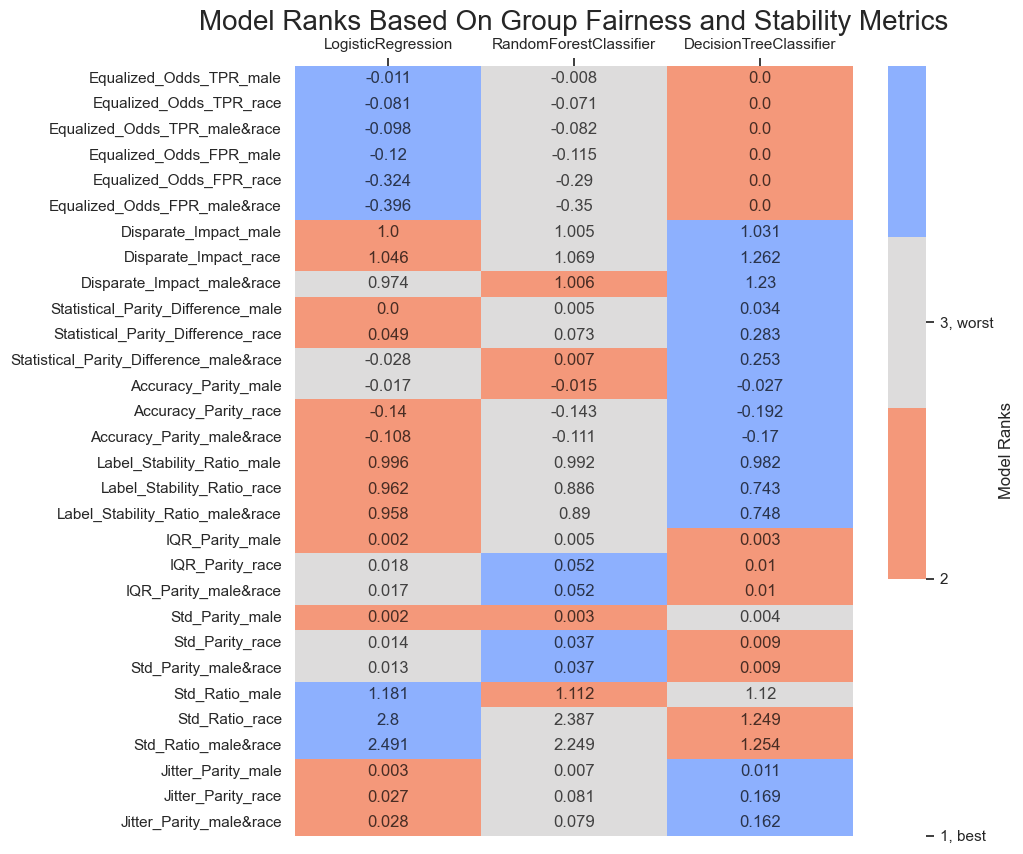

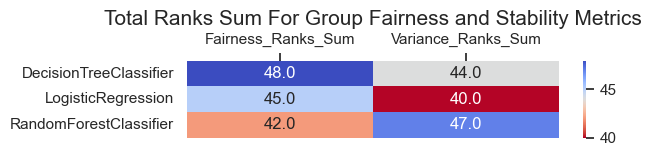

In [52]:
visualizer.create_model_rank_heatmaps(
    metrics_lst=[
        # Group fairness metrics
        'Equalized_Odds_TPR',
        'Equalized_Odds_FPR',
        'Disparate_Impact',
        'Statistical_Parity_Difference',
        'Accuracy_Parity',
        # Group stability metrics
        'Label_Stability_Ratio',
        'IQR_Parity',
        'Std_Parity',
        'Std_Ratio',
        'Jitter_Parity',
    ],
    groups_lst=config.sensitive_attributes_dct.keys(),
)